In [60]:
# Librerías
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Normalización
from sklearn.preprocessing import StandardScaler

# Machine Learning
import torch
import torch.nn as nn
from torch.optim import AdamW


Serie de tiempo sintética sobre horas de sueño.

        date  sleep_hours    month
0 2015-01-01     8.245071  2015-01
1 2015-01-02     7.292604  2015-01
2 2015-01-03     8.471533  2015-01
3 2015-01-04     9.784545  2015-01
4 2015-01-05     7.148770  2015-01


<Axes: title={'center': 'Serie de tiempo sintética: Horas de sueño promedio'}, xlabel='date'>

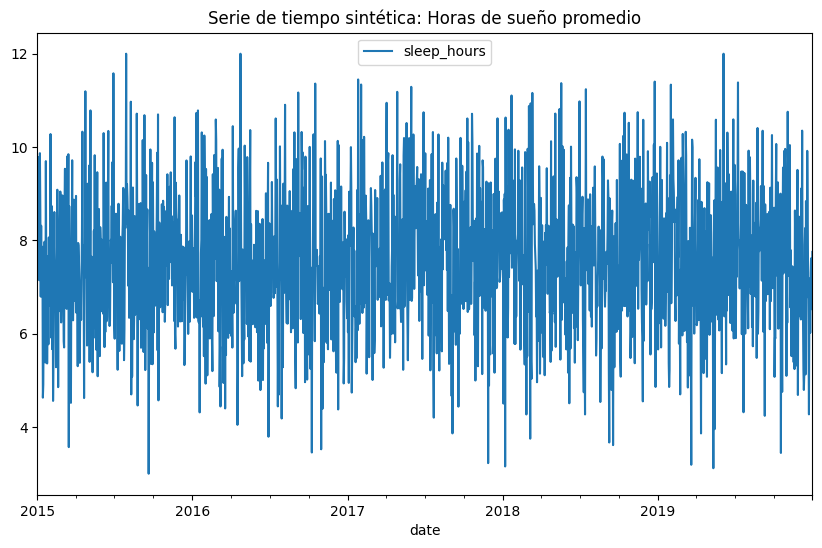

In [62]:
# Parámetros para la simulación
np.random.seed(42)  # Fijar semilla para reproducibilidad
n_years = 5
days_per_year = 365
total_days = n_years * days_per_year

# Valores de la serie (en horas de sueño promedio diarias)
mean_sleep = 7.5  # Promedio de horas de sueño
std_sleep = 1.5   # Desviación estándar

# Generar datos con distribución normal
sleep_data = np.clip(
    np.random.normal(loc=mean_sleep, scale=std_sleep, size=total_days),
    a_min=3, a_max=12  # Limitar a rango [3, 12]
)

# Crear un DataFrame con fechas y la serie de tiempo
date_range = pd.date_range(start="2015-01-01", periods=total_days, freq="D")
synthetic_sleep_data = pd.DataFrame({"date": date_range, "sleep_hours": sleep_data})

synthetic_sleep_data["month"] = synthetic_sleep_data["date"].dt.to_period("M")

# Visualización inicial
print(synthetic_sleep_data.head())
synthetic_sleep_data.plot(x="date", y="sleep_hours", title="Serie de tiempo sintética: Horas de sueño promedio", figsize=(10, 6))


In [63]:
# Configurar el índice de fechas
synthetic_sleep_data['date'] = pd.to_datetime(synthetic_sleep_data['date'])
synthetic_sleep_data = synthetic_sleep_data.set_index('date')

In [64]:
# Procesamiento de la serie
scaler = StandardScaler()
sleep_scaled = scaler.fit_transform(synthetic_sleep_data[['sleep_hours']].values)

In [81]:
# Preparación de datos para entrenamiento
sequence_length = 30  # Usar datos de un mes para predecir el promedio del siguiente

# Escalar para usar todos los valores de un mes previo y calcular el promedio mensual siguiente
sleep_data = synthetic_sleep_data["sleep_hours"].values  # Valores diarios de la serie

# Crear secuencias
def create_sequences(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Los últimos `seq_length` días
        Y.append(data[i+seq_length])   # El valor del siguiente día
    return np.array(X), np.array(Y)

# Crear las secuencias usando los promedios mensuales
X_sleep, Y_sleep = create_sequences(sleep_data, sequence_length)

# Verificar las formas de las secuencias
print(f"Shape de X (secuencias de entrada): {X_sleep.shape}")
print(f"Shape de Y (valores objetivo): {Y_sleep.shape}")

Shape de X (secuencias de entrada): (1795, 30)
Shape de Y (valores objetivo): (1795,)


In [82]:
# Agregar una nueva dimensión para convertir X en tridimensional (num_sequences, sequence_length, 1)
X_sleep = X_sleep[..., np.newaxis] 

In [83]:
print("Shape de X (secuencias):", X_sleep.shape)
print("Shape de Y (valores):", Y_sleep.shape)

Shape de X (secuencias): (1795, 30, 1)
Shape de Y (valores): (1795,)


In [74]:
# División de datos en entrenamiento y prueba
split = int(0.8 * len(X_sleep))
X_sleep_train, Y_sleep_train = X_sleep[:split], Y_sleep[:split]
X_sleep_val, Y_sleep_val = X_sleep[split:], Y_sleep[split:]

# Convertir a tensores
X_sleep_train = torch.tensor(X_sleep_train, dtype=torch.float32)
Y_sleep_train = torch.tensor(Y_sleep_train, dtype=torch.float32)
X_sleep_val = torch.tensor(X_sleep_val, dtype=torch.float32)
Y_sleep_val = torch.tensor(Y_sleep_val, dtype=torch.float32)

In [75]:
# Clase para predecir un valor escalar a partir de una secuencia de datos de entrada. 

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout, seq_length):
        super(TimeSeriesTransformer, self).__init__()
        self.seq_length = seq_length
        self.d_model = d_model
        self.dropout = dropout
        
        # Embedding lineal para transformar la entrada a un tamaño d_model
        self.embedding = nn.Linear(input_dim, d_model)
        
        # Capa de Transformer Encoder
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dropout=dropout, 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        # Capa fully connected para la salida de un valor escalar
        self.fc = nn.Linear(d_model, 1)
        
        # Embedding posicional
        self._create_positional_embeddings(seq_length, d_model)

    def _create_positional_embeddings(self, seq_length, d_model):
        # Generar embeddings posicionales como matriz fija
        position = torch.arange(0, seq_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pos_embed = torch.zeros(seq_length, d_model)
        # Uso de funciones seno y coseno para capturar relaciones de posición
        pos_embed[:, 0::2] = torch.sin(position * div_term)
        pos_embed[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('position_embedding', pos_embed)

    def forward(self, x):
        # Proyección inicial con embeddings y embeddings posicionales
        x = self.embedding(x)  # Transformar input_dim a d_model
        x = x + self.position_embedding  # Agregar embeddings posicionales
        
        # Pasar por el Transformer Encoder
        x = self.transformer(x)
        
        # Seleccionar el último paso temporal de la salida del Transformer
        x = x[:, -1, :]  # Usar solo el último paso (d_model)
        
        # Pasar por la capa fully connected
        return self.fc(x).squeeze(-1)

In [76]:
# Definir el modelo y parámetros de entrenamiento
input_dim = 1  # Serie de tiempo univariable (horas de sueño)
d_model = 64
nhead = 4
num_layers = 4
dropout = 0.3

model = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, dropout, sequence_length)

# Entrenamiento
num_epochs = 50
train_losses = []
val_losses = []

# Función de pérdica y optimizador
learning_rate = 0.005
weight_decay=1e-4

criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
    )

for epoch in range(num_epochs):  
    # Entrenamiento del modelo
    model.train()
    optimizer.zero_grad()
    outputs = model(X_sleep_train)
    loss = criterion(outputs.squeeze(), Y_sleep_train)
    loss.backward()
    optimizer.step()
    train_loss = loss.item()

    # Validación
    model.eval()
    with torch.no_grad():
        outputs = model(X_sleep_val)
        val_loss = criterion(outputs.squeeze(), Y_sleep_val).item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Scheduler: Reduce la tasa de aprendizaje en un factor (factor=0.5) si la pérdida de validación no mejora durante 5 épocas.
    scheduler.step(val_loss)
    
    # Early Stopping: Detiene el entrenamiento si la pérdida de validación no mejora
    patience = 10
    best_val_loss = float('inf')
    epochs_no_improve = 0

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1: Train Loss: 62.8256, Val Loss: 14.0670
Epoch 2: Train Loss: 17.3948, Val Loss: 10.2608
Epoch 3: Train Loss: 13.8249, Val Loss: 9.0165
Epoch 4: Train Loss: 12.5414, Val Loss: 7.9205
Epoch 5: Train Loss: 11.2808, Val Loss: 6.6620
Epoch 6: Train Loss: 9.9309, Val Loss: 5.5257
Epoch 7: Train Loss: 8.5894, Val Loss: 4.5766
Epoch 8: Train Loss: 7.3929, Val Loss: 3.7846
Epoch 9: Train Loss: 6.2416, Val Loss: 3.1555
Epoch 10: Train Loss: 5.1943, Val Loss: 2.7017
Epoch 11: Train Loss: 4.2856, Val Loss: 2.4139
Epoch 12: Train Loss: 3.5499, Val Loss: 2.2693
Epoch 13: Train Loss: 2.9368, Val Loss: 2.2618
Epoch 14: Train Loss: 2.4843, Val Loss: 2.3909
Epoch 15: Train Loss: 2.2510, Val Loss: 2.6282
Epoch 16: Train Loss: 2.1833, Val Loss: 2.9112
Epoch 17: Train Loss: 2.2644, Val Loss: 3.1392
Epoch 18: Train Loss: 2.3281, Val Loss: 3.1763
Epoch 19: Train Loss: 2.4122, Val Loss: 2.9965
Epoch 20: Train Loss: 2.3370, Val Loss: 2.8449
Epoch 21: Train Loss: 2.3159, Val Loss: 2.6894
Epoch 22: Train

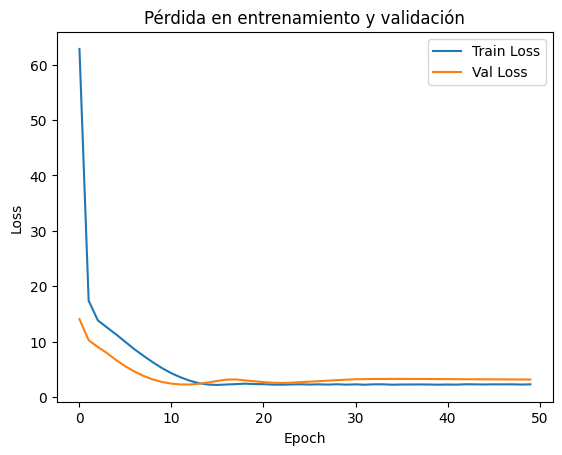

In [77]:
# Graficar pérdidas
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')  
plt.ylabel('Loss')
plt.title('Pérdida en entrenamiento y validación')
plt.show()

Serie de tiempo sintética sobre frecuencia cardíaca.

        date  heart_rate    month
0 2015-01-01       74.97  2015-01
1 2015-01-02       68.62  2015-01
2 2015-01-03       76.48  2015-01
3 2015-01-04       85.23  2015-01
4 2015-01-05       67.66  2015-01


<Axes: title={'center': 'Serie de tiempo sintética: Frecuencia cardíaca promedio'}, xlabel='date'>

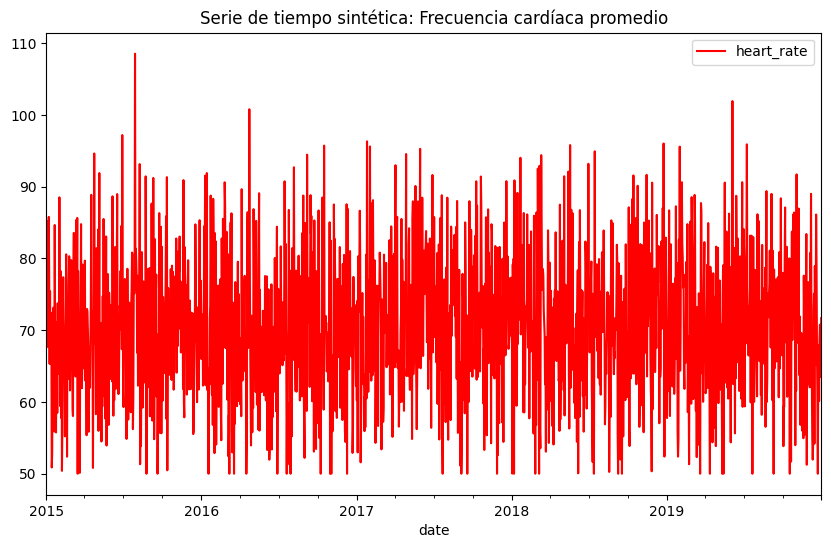

In [86]:
# Parámetros para la simulación
np.random.seed(42)  # Fijar semilla para reproducibilidad
n_years = 5
days_per_year = 365
total_days = n_years * days_per_year

# Valores de la serie (frecuencia cardíaca promedio diaria en latidos por minuto)
mean_hr = 70  # Promedio de frecuencia cardíaca
std_hr = 10   # Desviación estándar

# Generar datos con distribución normal
heart_rate_data = np.clip(
    np.random.normal(loc=mean_hr, scale=std_hr, size=total_days),
    a_min=50, a_max=120  # Limitar a rango [50, 120]
)

# Redondear los valores de heart_rate a 2 dígitos
heart_rate_data = np.round(heart_rate_data, 2)

# Crear un DataFrame con fechas y la serie de tiempo
date_range = pd.date_range(start="2015-01-01", periods=total_days, freq="D")
synthetic_hr_data = pd.DataFrame({"date": date_range, "heart_rate": heart_rate_data})

synthetic_hr_data["month"] = synthetic_hr_data["date"].dt.to_period("M")

# Visualización inicial
print(synthetic_hr_data.head())
synthetic_hr_data.plot(x="date", y="heart_rate", title="Serie de tiempo sintética: Frecuencia cardíaca promedio", figsize=(10, 6), color='red')

In [87]:
# Configurar el índice de fechas
synthetic_hr_data['date'] = pd.to_datetime(synthetic_hr_data['date'])
synthetic_hr_data = synthetic_hr_data.set_index('date')

In [88]:
# Procesamiento de la serie
scaler = StandardScaler()
hr_scaled = scaler.fit_transform(synthetic_hr_data[['heart_rate']].values)

In [89]:
# Preparación de datos para entrenamiento
sequence_length = 30  # Usar datos de un mes para predecir el siguiente día

# Crear las secuencias usando los valores diarios
hr_data = synthetic_hr_data["heart_rate"].values  # Valores diarios de la serie
X_hr, Y_hr = create_sequences(hr_data, sequence_length)

# Agregar una nueva dimensión para convertir X en tridimensional (num_sequences, sequence_length, 1)
X_hr = X_hr[..., np.newaxis]

# Verificar las formas de las secuencias
print(f"Shape de X_hr (secuencias de entrada): {X_hr.shape}")
print(f"Shape de Y_hr (valores objetivo): {Y_hr.shape}")

Shape de X_hr (secuencias de entrada): (1795, 30, 1)
Shape de Y_hr (valores objetivo): (1795,)


In [90]:
# División de datos en entrenamiento y prueba
split = int(0.8 * len(X_hr))
X_hr_train, Y_hr_train = X_hr[:split], Y_hr[:split]
X_hr_val, Y_hr_val = X_hr[split:], Y_hr[split:]

# Convertir a tensores
X_hr_train = torch.tensor(X_hr_train, dtype=torch.float32)
Y_hr_train = torch.tensor(Y_hr_train, dtype=torch.float32)
X_hr_val = torch.tensor(X_hr_val, dtype=torch.float32)
Y_hr_val = torch.tensor(Y_hr_val, dtype=torch.float32)

In [91]:
# Definir el modelo y parámetros de entrenamiento
input_dim = 1  # Serie de tiempo univariable (horas de sueño)
d_model = 64
nhead = 4
num_layers = 4
dropout = 0.3

model = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, dropout, sequence_length)

# Entrenamiento
num_epochs = 50
train_losses = []
val_losses = []

# Función de pérdica y optimizador
learning_rate = 0.005
weight_decay=1e-4

criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
    )

for epoch in range(num_epochs):  
    # Entrenamiento del modelo
    model.train()
    optimizer.zero_grad()
    outputs = model(X_hr_train)
    loss = criterion(outputs.squeeze(), Y_hr_train)
    loss.backward()
    optimizer.step()
    train_loss = loss.item()

    # Validación
    model.eval()
    with torch.no_grad():
        outputs = model(X_hr_val)
        val_loss = criterion(outputs.squeeze(), Y_hr_val).item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Scheduler: Reduce la tasa de aprendizaje en un factor (factor=0.5) si la pérdida de validación no mejora durante 5 épocas.
    scheduler.step(val_loss)
    
    # Early Stopping: Detiene el entrenamiento si la pérdida de validación no mejora
    patience = 10
    best_val_loss = float('inf')
    epochs_no_improve = 0

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1: Train Loss: 5154.1982, Val Loss: 4442.0430
Epoch 2: Train Loss: 4514.4141, Val Loss: 4370.4980
Epoch 3: Train Loss: 4452.7178, Val Loss: 4339.4897


KeyboardInterrupt: 

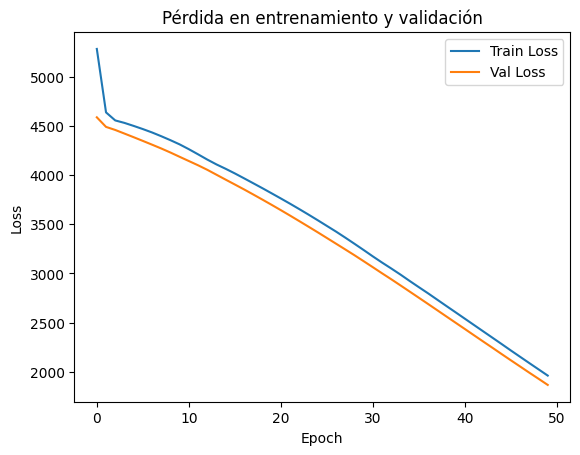

In [47]:
# Graficar pérdidas
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')  
plt.ylabel('Loss')
plt.title('Pérdida en entrenamiento y validación')
plt.show()

Multivariate training

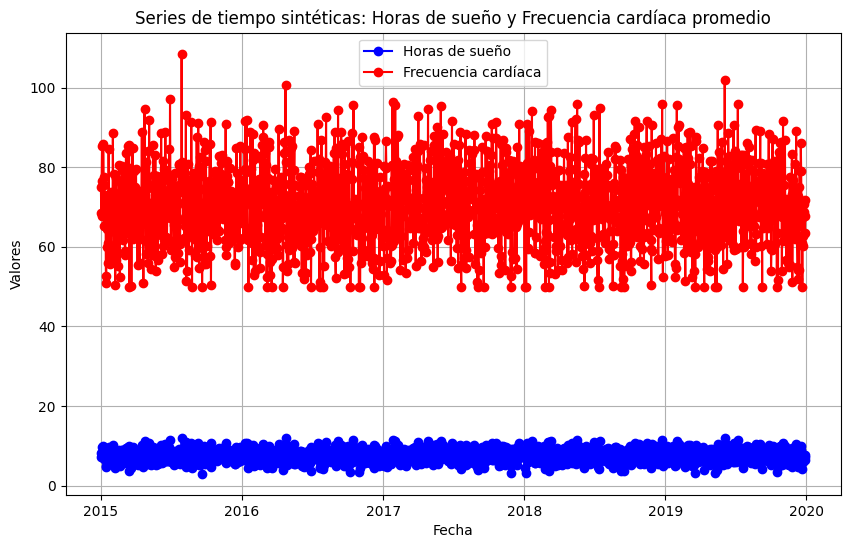

In [95]:
total_months = n_years * 12
date_range = pd.date_range(start="2015-01-01", periods=total_days, freq="D")

# Visualización unificada
plt.figure(figsize=(10, 6))
plt.plot(date_range, synthetic_sleep_data['sleep_hours'], marker='o', linestyle='-', label='Horas de sueño', color='blue')
plt.plot(date_range, synthetic_hr_data['heart_rate'], marker='o', linestyle='-', label='Frecuencia cardíaca', color='red')
plt.title("Series de tiempo sintéticas: Horas de sueño y Frecuencia cardíaca promedio")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.show()

In [92]:
def create_sequences_multivariate(data1, data2, seq_length):
    X, Y = [], []
    for i in range(len(data1) - seq_length):
        # Concatenar ambas series
        X.append(np.stack((data1[i:i+seq_length], data2[i:i+seq_length]), axis=1))
        Y.append(data1[i+seq_length])  # Objetivo: predicción basada en la primera serie
    return np.array(X), np.array(Y)

In [93]:
scaler_sleep = StandardScaler()
scaler_heart = StandardScaler()

sleep_scaled = scaler_sleep.fit_transform(sleep_data.reshape(-1, 1))
heart_scaled = scaler_heart.fit_transform(heart_rate_data.reshape(-1, 1))

In [94]:
X, Y = create_sequences_multivariate(sleep_scaled, heart_scaled, sequence_length)